<a href="https://colab.research.google.com/github/twyeh/highenergy/blob/main/FrequentistFit_VubVcb_Profiler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install flavio

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.5/290.5 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.8/594.8 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.7 MB/s eta 0:00:00
  Created wheel for parton: filename=parton-0.2.2-py3-none-any.whl size=14000 sha256=01aa01515bb2959235959393928afc8a6ad88bfc47c26822341c3a43f519b536
  Stored in directory: /root/.cache/pip/wheels/4f/5f/ba/4a4c454a28005125067382ffc0c3e967429b658917d062d75e
  Created wheel for pylha: filename=pylha-0.4-py3-none-any.whl size=58269 sha256=37bbaf7e09b3b9c506411ba42ca06d0813005adf348d3f5c5e563d754bc8e485
  Stored in directory: /root/.cache/pip/wheels/e5/fa/51/6cb033ac4cb2857410fa6e15c87a4501df116007d79c91b473
Successfully

In [1]:
!apt-get update
!apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [73.0 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,836 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Package

In [4]:
"""A fit is a collection of observables and parameters that can be used to
perform statistical analyses within a particular statistical framework.

Fits are instances of descendants of the `Fit` class (which is not meant
to be used directly)

Note that this module has been deprecated as of flavio v1.6.0. Please
use the `flavio.statistics.likelihood` module instead."""

import warnings
warnings.warn("The `flavio.statistics.fits` module has been deprecated"
              " as of flavio v1.6.0. Please use the `flavio.statistics.likelihood`"
              " module instead.",
              DeprecationWarning, stacklevel=2)


import flavio
import numpy as np
from flavio.statistics.probability import NormalDistribution, MultivariateNormalDistribution
from flavio.math.optimize import minimize_robust
from collections import Counter, OrderedDict
import warnings
import inspect
from multiprocessing import Pool
import scipy.optimize
import pickle
from functools import partial
import yaml


class Fit(flavio.NamedInstanceClass):
    """Base class for fits. Not meant to be used directly."""

    def __init__(self,
                 name,
                 par_obj=flavio.default_parameters,
                 fit_parameters=None,
                 nuisance_parameters=None,
                 observables=None,
                 fit_wc_names=None,
                 fit_wc_function=None,
                 fit_wc_priors=None,
                 input_scale=160.,
                 exclude_measurements=None,
                 include_measurements=None,
                 fit_wc_eft='WET',
                 fit_wc_basis='flavio',
                ):
        if fit_parameters is None:
            self.fit_parameters = []
        else:
            self.fit_parameters = fit_parameters
        if nuisance_parameters is None:
            self.nuisance_parameters = []
        elif nuisance_parameters == 'all':
            self.nuisance_parameters = par_obj.all_parameters
        else:
            self.nuisance_parameters = nuisance_parameters
        if observables is None:
            raise ValueError("'observables' is empty: you must specify at least one fit observable")
        if fit_wc_names is not None:
            warnings.warn("The 'fit_wc_names' argument is no longer necessary "
            "as of flavio v0.19 and might be removed in the future.",
            FutureWarning)
        # some checks to make sure the input is sane
        for p in self.nuisance_parameters:
            # check that nuisance parameters are constrained
            assert p in par_obj._parameters.keys(), "Parameter " + p + " not found in Constraints"
        for obs in observables:
            # check that observables exist
            try:
                if isinstance(obs, tuple):
                    flavio.classes.Observable[obs[0]]
                elif isinstance(obs, dict):
                    flavio.classes.Observable[obs['name']]
                elif isinstance(obs, str):
                    flavio.classes.Observable[obs]
                else:
                    ValueError("Unexpected form of observable: {}".format(obs))
            except:
                raise ValueError("Observable " + str(obs) + " not found!")
        _obs_measured = set()
        if exclude_measurements and include_measurements:
            raise ValueError("The options exclude_measurements and include_measurements must not be specified simultaneously")
        # check that no parameter appears as fit *and* nuisance parameter
        intersect = set(self.fit_parameters).intersection(self.nuisance_parameters)
        assert intersect == set(), "Parameters appearing as fit_parameters and nuisance_parameters: " + str(intersect)
        # check that the Wilson coefficient function works
        if fit_wc_function is not None: # if list of WC names not empty
            try:
                self.fit_wc_names = tuple(inspect.signature(fit_wc_function).parameters.keys())
                fit_wc_function(**{fit_wc_name: 1e-6 for fit_wc_name in self.fit_wc_names})
            except:
                raise ValueError("Error in calling the Wilson coefficient function")
        else:
            self.fit_wc_names = tuple()
        # now that everything seems fine, we can call the init of the parent class
        super().__init__(name)
        self.par_obj = par_obj
        self.parameters_central = self.par_obj.get_central_all()
        self.exclude_measurements = exclude_measurements
        self.include_measurements = include_measurements
        self.fit_wc_function = fit_wc_function
        self.fit_wc_priors = fit_wc_priors
        self.observables = observables
        self.input_scale = input_scale
        self._warn_meas_corr

        # check that observables are constrained
        for m_name in self.get_measurements:
            m_obj = flavio.Measurement[m_name]
            _obs_measured.update(m_obj.all_parameters)
        missing_obs = set(observables) - set(_obs_measured).intersection(set(observables))
        assert missing_obs == set(), "No measurement found for the observables: " + str(missing_obs)

        self.dimension = len(self.fit_parameters) + len(self.nuisance_parameters) + len(self.fit_wc_names)
        self.eft = fit_wc_eft
        self.basis = fit_wc_basis

    @property
    def get_central_fit_parameters(self):
        """Return a numpy array with the central values of all fit parameters."""
        return np.asarray([self.parameters_central[p] for p in self.fit_parameters])

    @property
    def get_random_fit_parameters(self):
        """Return a numpy array with random values for all fit parameters."""
        all_random = self.par_obj.get_random_all()
        return np.asarray([all_random[p] for p in self.fit_parameters])

    @property
    def get_random_wilson_coeffs(self):
        """Return a numpy array with random values for all Wilson coefficients."""
        if self.fit_wc_priors is None:
            return None
        all_random = self.fit_wc_priors.get_random_all()
        return np.asarray([all_random[p] for p in self.fit_wc_names])

    @property
    def get_central_nuisance_parameters(self):
        """Return a numpy array with the central values of all nuisance parameters."""
        return np.asarray([self.parameters_central[p] for p in self.nuisance_parameters])

    @property
    def get_random_nuisance_parameters(self):
        """Return a numpy array with random values for all nuisance parameters."""
        all_random = self.par_obj.get_random_all()
        return np.asarray([all_random[p] for p in self.nuisance_parameters])

    @property
    def get_measurements(self):
        """Return a list of all the measurements currently defined that
        constrain any of the fit observables."""
        all_measurements = []
        for m_name, m_obj in flavio.classes.Measurement.instances.items():
            if m_name.split(' ')[0] == 'Pseudo-measurement':
                # skip pseudo measurements generated by FastFit instances
                continue
            if set(m_obj.all_parameters).isdisjoint(self.observables):
                # if set of all observables constrained by measurement is disjoint
                # with fit observables, do nothing
                continue
            else:
                # else, add measurement name to output list
                all_measurements.append(m_name)
        if self.exclude_measurements is None and self.include_measurements is None:
            return all_measurements
        elif self.exclude_measurements is not None:
            return list(set(all_measurements) - set(self.exclude_measurements))
        elif self.include_measurements is not None:
            return list(set(all_measurements) & set(self.include_measurements))

    @property
    def _warn_meas_corr(self):
        """Warn the user if the fit contains multiple correlated measurements of
        an observable that is not included in the fit parameters, as this will
        lead to inconsistent results."""
        corr_with = {}
        # iterate over all measurements constraining at least one fit obs.
        for name in self.get_measurements:
            m = flavio.classes.Measurement[name]
            # iterate over all fit obs. constrained by this measurement
            for obs in set(self.observables) & set(m.all_parameters):
                # the constraint on this fit obs.
                constraint = m._parameters[obs][1]
                # find all the other obs. constrained by this constraint
                for c, p in m._constraints:
                    if c == constraint:
                        par = p
                        break
                for p in par:
                    # if the other obs. are not fit obs., append them to the list
                    if p not in self.observables:
                        if p not in corr_with:
                            corr_with[p] = [obs]
                        else:
                            corr_with[p].append(obs)
        # replace list by a Counter
        corr_with = {k: Counter(v) for k, v in corr_with.items() if v}
        # warn for all counts > 1
        for obs1, counter in corr_with.items():
            for obs2, count in counter.items():
                if count > 1:
                    warnings.warn(("{} of the measurements in the fit '{}' "
                                   "constrain both '{}' and '{}', but only the "
                                   "latter is included among the fit "
                                   "observables. This can lead to inconsistent "
                                   "results as the former is profiled over."
                                   ).format(count, self.name, obs1, obs2))
        return corr_with


    def array_to_dict(self, x):
        """Convert a 1D numpy array of floats to a dictionary of fit parameters,
        nuisance parameters, and Wilson coefficients."""
        d = {}
        n_fit_p = len(self.fit_parameters)
        n_nui_p = len(self.nuisance_parameters)
        n_wc = len(self.fit_wc_names)
        d['fit_parameters'] = { p: x[i] for i, p in enumerate(self.fit_parameters) }
        d['nuisance_parameters'] = { p: x[i + n_fit_p] for i, p in enumerate(self.nuisance_parameters) }
        d['fit_wc'] = { p: x[i + n_fit_p + n_nui_p] for i, p in enumerate(self.fit_wc_names) }
        return d

    def dict_to_array(self, d):
        """Convert a dictionary of fit parameters,
        nuisance parameters, and Wilson coefficients to a 1D numpy array of
        floats."""
        n_fit_p = len(self.fit_parameters)
        n_nui_p = len(self.nuisance_parameters)
        n_wc = len(self.fit_wc_names)
        arr = np.zeros(n_fit_p + n_nui_p + n_wc)
        arr[:n_fit_p] = [d['fit_parameters'][p] for p in self.fit_parameters]
        arr[n_fit_p:n_fit_p+n_nui_p] = [d['nuisance_parameters'][p] for p in self.nuisance_parameters]
        arr[n_fit_p+n_nui_p:]   = [d['fit_wc'][c] for c in self.fit_wc_names]
        return arr

    @property
    def get_random(self):
        """Get an array with random values for all the fit and nuisance
        parameters and Wilson coefficients."""
        return self._get_random()

    def _get_random(self, par=True, nuisance=True, wc=True):
        """Get an array with random values for all the fit and nuisance
        parameters and Wilson coefficients.

        If par is False, fit parameters are set to their central values.
        If nuisance is False, nuisance parameters are set to their central values.
        """
        arr = np.zeros(self.dimension)
        n_fit_p = len(self.fit_parameters)
        n_nui_p = len(self.nuisance_parameters)
        if par:
            arr[:n_fit_p] = self.get_random_fit_parameters
        else:
            arr[:n_fit_p] = self.get_central_fit_parameters
        if nuisance:
            arr[n_fit_p:n_fit_p+n_nui_p] = self.get_random_nuisance_parameters
        else:
            arr[n_fit_p:n_fit_p+n_nui_p] = self.get_central_nuisance_parameters
        if wc:
            arr[n_fit_p+n_nui_p:] = self.get_random_wilson_coeffs
        return arr

    @property
    def get_random_wilson_coeffs_start(self):
        """Return a numpy array with random values for all Wilson coefficients
        sampling the start_wc_priors distribution."""
        if self.fit_wc_function is None:
            # no Wilson coefficients present
            return None
        elif self.start_wc_priors is None:
            if self.fit_wc_priors is None:
                raise ValueError("Starting values can only be generated if"
                        " either fit_wc_priors or start_wc_priors is defined")
            else:
                return self.get_random_wilson_coeffs
        all_random = self.start_wc_priors.get_random_all()
        return np.asarray([all_random[p] for p in self.fit_wc_names])

    @property
    def get_random_start(self):
        """Get an array with random values for all the fit and nuisance
        parameters with Wilson coefficients set to their SM values"""
        arr = np.zeros(self.dimension)
        n_fit_p = len(self.fit_parameters)
        n_nui_p = len(self.nuisance_parameters)
        arr[:n_fit_p] = self.get_random_fit_parameters
        arr[n_fit_p:n_fit_p+n_nui_p] = self.get_random_nuisance_parameters
        arr[n_fit_p+n_nui_p:] = self.get_random_wilson_coeffs_start
        return arr

    def get_par_dict(self, x, par=True, nuisance=True):
        """Get a dictionary of fit and nuisance parameters from an input array

        If par is False, fit parameters are set to their central values.
        If nuisance is False, nuisance parameters are set to their central values.
        """
        d = self.array_to_dict(x)
        par_dict = self.parameters_central.copy()
        if par:
            par_dict.update(d['fit_parameters'])
        if nuisance:
            par_dict.update(d['nuisance_parameters'])
        return par_dict

    def get_wc_obj(self, x):
        wc_obj = flavio.WilsonCoefficients()
        # if there are no WCs to be fitted, return the SM WCs
        if not self.fit_wc_names:
            return wc_obj
        d = self.array_to_dict(x)
        wc_obj.set_initial(self.fit_wc_function(**d['fit_wc']), self.input_scale,
                           eft=self.eft, basis=self.basis)
        return wc_obj

    def log_prior_parameters(self, x):
        """Return the prior probability for all fit and nuisance parameters
        given an input array"""
        par_dict = self.get_par_dict(x)
        exclude_parameters = list(set(par_dict.keys())-set(self.fit_parameters)-set(self.nuisance_parameters))
        prob_dict = self.par_obj.get_logprobability_all(par_dict, exclude_parameters=exclude_parameters)
        return sum([p for obj, p in prob_dict.items()])

    def log_prior_wilson_coeffs(self, x):
        """Return the prior probability for all Wilson coefficients
        given an input array"""
        if self.fit_wc_priors is None:
            return 0
        wc_dict = self.array_to_dict(x)['fit_wc']
        prob_dict = self.fit_wc_priors.get_logprobability_all(wc_dict)
        return sum([p for obj, p in prob_dict.items()])

    def get_predictions(self, x, par=True, nuisance=True, wc=True):
        """Get a dictionary with predictions for all observables given an input
        array.

        If par is False, fit parameters are set to their central values.
        If nuisance is False, nuisance parameters are set to their central values.
        If wc is False, Wilson coefficients are set to their SM values.
        """
        par_dict = self.get_par_dict(x, par=par, nuisance=nuisance)
        if wc:
            wc_obj = self.get_wc_obj(x)
        else:
            wc_obj = flavio.physics.eft._wc_sm
        all_predictions = {}
        for observable in self.observables:
            if isinstance(observable, tuple):
                obs_name = observable[0]
                _inst = flavio.classes.Observable[obs_name]
                all_predictions[observable] = _inst.prediction_par(par_dict, wc_obj, *observable[1:])
            else:
                _inst = flavio.classes.Observable[observable]
                all_predictions[observable] = _inst.prediction_par(par_dict, wc_obj)
        return all_predictions

    def get_predictions_array(self, x, **kwargs):
        pred = self.get_predictions(x, **kwargs)
        return np.array([pred[obs] for obs in self.observables])

    def log_prior_parameters(self, x):
        """Return the prior probability (or frequentist likelihood) for all
        fit and (!) nuisance parameters given an input array"""
        par_dict = self.get_par_dict(x)
        exclude_parameters = list(set(par_dict.keys())-set(self.fit_parameters)-set(self.nuisance_parameters))
        prob_dict = self.par_obj.get_logprobability_all(par_dict, exclude_parameters=exclude_parameters)
        return sum([p for obj, p in prob_dict.items()])

    def log_prior_nuisance_parameters(self, x):
        """Return the prior probability (or frequentist likelihood) for all
        nuisance parameters given an input array"""
        par_dict = self.get_par_dict(x)
        exclude_parameters = list(set(par_dict.keys())-set(self.nuisance_parameters))
        prob_dict = self.par_obj.get_logprobability_all(par_dict, exclude_parameters=exclude_parameters)
        return sum([p for obj, p in prob_dict.items()])

    def log_likelihood_exp(self, x):
        """Return the logarithm of the likelihood function (not including the
        prior)"""
        predictions = self.get_predictions(x)
        ll = 0.
        for measurement in self.get_measurements:
            m_obj = flavio.Measurement[measurement]
            m_obs = m_obj.all_parameters
            exclude_observables = set(m_obs) - set(self.observables)
            prob_dict = m_obj.get_logprobability_all(predictions, exclude_parameters=exclude_observables)
            ll += sum(prob_dict.values())
        return ll


class BayesianFit(Fit):
    r"""Bayesian fit class. Instances of this class can then be fed to samplers.

    Parameters
    ----------

    - `name`: a descriptive string name
    - `par_obj`: optional; an instance of `ParameterConstraints`.
      Defaults to `flavio.default_parameters`
    - `fit_parameters`: a list of string names of parameters of interest. The existing
      constraints on the parameter will be taken as prior.
    - `nuisance_parameters`: a list of string names of nuisance parameters. The existing
      constraints on the parameter will be taken as prior. Alternatively, it
      can also be set to 'all', in which case all the parameters constrainted
      by `par_obj` will be treated as nuisance parameters. (Note that this makes
      sense for `FastFit`, but not for a MCMC since the number of nuisance
      parameters will be huge.)
    - `observables`: a list of observable names to be included in the fit
    - `exclude_measurements`: optional; a list of measurement names *not* to be included in
    the fit. By default, all existing measurements are included.
    - `include_measurements`: optional; a list of measurement names to be included in
    the fit. By default, all existing measurements are included.
    - `fit_wc_names`: optional; a list of string names of arguments of the Wilson
      coefficient function below
    - `fit_wc_function`: optional; a function that
      returns a dictionary that can be fed to the `set_initial`
      method of the Wilson coefficient class. Example: fit the real and imaginary
      parts of $C_{10}$ in $b\to s\mu^+\mu^-$.
    ```
    def fit_wc_function(Re_C10, Im_C10):
        return {'C10_bsmmumu': Re_C10 + 1j*Im_C10}
    ```
    - `input_scale`: input scale for the Wilson coeffficients. Defaults to 160.
    - `fit_wc_priors`: optional; an instance of WilsonCoefficientPriors
      containing prior constraints on the Wilson coefficients
    - `start_wc_priors`: optional; an instance of WilsonCoefficientPriors
      that will not be used during a scan, but only for finding starting values
      for Wilson coefficients in MCMC analyses. This can be useful if no
      actual priors are used or if they are too loose to provide good starting
      points.
    """

    def __init__(self, *args, start_wc_priors=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.start_wc_priors = start_wc_priors

        for p in self.fit_parameters:
            # check that fit parameters are constrained
            assert p in self.par_obj._parameters.keys(), "Parameter " + p + " not found in Constraints"

    @property
    def get_random(self):
        """Get an array with random values for all the fit and nuisance
        parameters"""
        arr = np.zeros(self.dimension)
        n_fit_p = len(self.fit_parameters)
        n_nui_p = len(self.nuisance_parameters)
        arr[:n_fit_p] = self.get_random_fit_parameters
        arr[n_fit_p:n_fit_p+n_nui_p] = self.get_random_nuisance_parameters
        arr[n_fit_p+n_nui_p:] = self.get_random_wilson_coeffs
        return arr

    def log_target(self, x):
        """Return the logarithm of the likelihood times prior probability"""
        return self.log_likelihood_exp(x) + self.log_prior_parameters(x) + self.log_prior_wilson_coeffs(x)


class FastFit(Fit):
    r"""A fit class that is meant for producing fast likelihood contour plots.

    Calling the method `make_measurement`, a pseudo-measurement is generated
    that combines the actual experimental measurements with the theoretical
    uncertainties stemming from the nuisance parameters. This is done by
    generating random samples of the nuisance parameters and evaluating all
    observables within the Standard Model many times (100 by default).
    Then, the covariance of all predictions is extracted. Similarly, a covariance
    matrix for all experimental measurements is determined. Both covariance
    matrices are added and the resulting multivariate Gaussian treated as a
    single measurement.

    This approach has the advantage that two-dimensional plots of the likelihood
    can be produced without the need for sampling or profiling the other
    dimensions. However, several strong assumptions go into this method, most
    importantly,

    - all uncertainties - experimental and theoretical - are treated as Gaussian
    - the theoretical uncertainties in the presence of new physics are assumed
      to be equal to the ones in the SM
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.measurements = None
        self._sm_covariance = None
        self._exp_central_covariance = None
        self._get_predictions_array_sm = partial(self.get_predictions_array,
                                                 par=False, nuisance=True,
                                                 wc=False)


    # a method to get the mean and covariance of all measurements of all
    # observables of interest
    def _get_central_covariance_experiment(self, N=5000):
        means = []
        covariances = []
        for measurement in self.get_measurements:
            m_obj = flavio.Measurement[measurement]
            # obs. included in the fit and constrained by this measurement
            our_obs = set(m_obj.all_parameters).intersection(self.observables)
            # construct a dict. containing a vector of N random values for
            # each of these observables
            random_dict = {}
            for obs in our_obs:
                random_dict[obs] = np.zeros(N)
            for i in range(N):
                m_random = m_obj.get_random_all()
                for obs in our_obs:
                    random_dict[obs][i] = m_random[obs]
            # mean = np.zeros(len(self.observables))
            random_arr = np.zeros((len(self.observables), N))
            for i, obs in enumerate(self.observables):
                #     n = len(random_dict[obs])
                if obs in our_obs:
                    random_arr[i] = random_dict[obs]
            mean = np.mean(random_arr, axis=1)
            covariance = np.cov(random_arr)
            for i, obs in enumerate(self.observables):
                if obs not in our_obs:
                    covariance[:,i] = 0
                    covariance[i, :] = 0
                    covariance[i, i] = np.inf
            means.append(mean)
            covariances.append(covariance)
        # if there is only a single measuement
        if len(means) == 1:
            if len(means[0]) == 1:
                # if there is only a single observable
                return means[0][0], covariances[0]
            else:
                return means[0], covariances[0]
        # if there are severeal measurements, perform a weighted average
        else:
            # covariances: [Sigma_1, Sigma_2, ...]
            # means: [x_1, x_2, ...]
            # weights_ [W_1, W_2, ...] where W_i = (Sigma_i)^(-1)
            # weighted covariance is  (W_1 + W_2 + ...)^(-1) = Sigma
            # weigted mean is  Sigma.(W_1.x_1 + W_2.x_2 + ...) = x
            if len(self.observables) == 1:
                weights = np.array([1/c for c in covariances])
                weighted_covariance = 1/np.sum(weights, axis=0)
                weighted_mean = weighted_covariance * np.sum(
                                [np.dot(weights[i], means[i]) for i in range(len(means))])
            else:
                weights = [np.linalg.inv(c) for c in covariances]
                weighted_covariance = np.linalg.inv(np.sum(weights, axis=0))
                weighted_mean = np.dot(weighted_covariance, np.sum(
                                [np.dot(weights[i], means[i]) for i in range(len(means))],
                                axis=0))
            return weighted_mean, weighted_covariance

    def get_exp_central_covariance(self, N=5000, force=True):
        """Return the experimental central values and the covriance matrix of
        all observables.

        Parameters:

        - `N`: number of random computations (computing time is proportional
          to it; more means less random fluctuations.)
        - `force`: optional; if True (default), will recompute covariance even
          if it already has been computed.
        """
        if self._exp_central_covariance is None or force:
            self._exp_central_covariance = self._get_central_covariance_experiment(N=N)
        elif N != 5000:
            warnings.warn("Argument N={} ignored ".format(N) + \
                          "as experimental covariance has already been " + \
                          "computed. Recompute with get_exp_central_covariance.")
        return self._exp_central_covariance

    def save_exp_central_covariance(self, filename):
        """Save the experimental central values and the covriance to a pickle
        file.

        The central values and the covariance must have been computed before
        using `get_exp_central_covariance`."""
        if self._exp_central_covariance is None:
            raise ValueError("Call get_exp_central_covariance or make_measurement first.")
        with open(filename, 'wb') as f:
            data = dict(central=self._exp_central_covariance[0],
                        covariance=self._exp_central_covariance[1],
                        observables=self.observables)
            pickle.dump(data, f)

    def load_exp_central_covariance(self, filename):
        """Load the experimental central values and the covriance from a pickle
        file."""
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        self.load_exp_central_covariance_dict(d=data)

    def load_exp_central_covariance_dict(self, d):
        """Load the the experimental central values and the covriancee from a
        dictionary.

        It must have the form
        {'observables': [...], 'central': [...], 'covariance': [[...]]}
        where 'central' is a vector of central values and 'covariance' is a
        covariance matrix, both in the basis of observables given by
        'observables' which must at least contain all the observables
        involved in the fit. Additional observables will be ignored; the
        ordering is arbitrary."""
        obs = d['observables']
        try:
            permutation = [obs.index(o) for o in self.observables]
        except ValueError:
            raise ValueError("Covariance matrix does not contain all necessary entries")
        assert len(permutation) == len(self.observables), \
            "Covariance matrix does not contain all necessary entries"
        if len(permutation) == 1:
            self._exp_central_covariance = (
                d['central'],
                d['covariance']
            )
        else:
            self._exp_central_covariance = (
                d['central'][permutation],
                d['covariance'][permutation][:,permutation],
            )

    # a method to get the covariance of the SM prediction of all observables
    # of interest
    def _get_random_nuisance(self, *args):
        return self._get_random(par=False, nuisance=True, wc=False)

    def _get_covariance_sm(self, N=100, threads=1):
        if threads == 1:
            X_map = map(self._get_random_nuisance, range(N))
            pred_map = map(self._get_predictions_array_sm, X_map)
        else:
            pool = Pool(threads)
            X_map = pool.map(self._get_random_nuisance, range(N))
            pred_map = pool.map(self._get_predictions_array_sm, X_map)
            pool.close()
            pool.join()
        pred_arr = np.empty((N, len(self.observables)))
        for i, pred_i in enumerate(pred_map):
            pred_arr[i] = pred_i
        return np.cov(pred_arr.T)

    def get_sm_covariance(self, N=100, threads=1, force=True):
        """Return the covriance matrix of the SM predictions of all observables
        under variation of all nuisance parameters.

        Parameters:

        - `N`: number of random computations (computing time is proportional
          to it; more means less random fluctuations.)
        - `threads`: optional; number of parallel threads. Defaults to 1 (no
          parallelization)
        - `force`: optional; if True (default), will recompute covariance even
          if it already has been computed.
        """
        if self._sm_covariance is None or force:
            self._sm_covariance = self._get_covariance_sm(N=N, threads=threads)
        elif N != 100:
            warnings.warn("Argument N={} ignored ".format(N) + \
                          "as SM covariance has already " + \
                          "been computed. Recompute with get_sm_covariance.")
        return self._sm_covariance

    def save_sm_covariance(self, filename):
        """Save the SM covariance to a pickle file.

        The covariance must have been computed before using
        `get_sm_covariance`."""
        if self._sm_covariance is None:
            raise ValueError("Call get_sm_covariance or make_measurement first.")
        with open(filename, 'wb') as f:
            data = dict(covariance=self._sm_covariance,
                        observables=self.observables)
            pickle.dump(data, f)

    def load_sm_covariance(self, filename):
        """Load the SM covariance from a pickle file."""
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        self.load_sm_covariance_dict(d=data)

    def load_sm_covariance_dict(self, d):
        """Load the SM covariance from a dictionary.

        It must have the form {'observables': [...], 'covariance': [[...]]}
        where 'covariance' is a covariance matrix in the basis of observables
        given by 'observables' which must at least contain all the observables
        involved in the fit. Additional observables will be ignored; the
        ordering is arbitrary."""
        obs = d['observables']
        try:
            permutation = [obs.index(o) for o in self.observables]
        except ValueError:
            raise ValueError("Covariance matrix does not contain all necessary entries")
        assert len(permutation) == len(self.observables), \
            "Covariance matrix does not contain all necessary entries"
        if len(permutation) == 1:
            if d['covariance'].shape == ():
                self._sm_covariance = d['covariance']
            else:
                self._sm_covariance = d['covariance'][permutation][:,permutation][0,0]
        else:
            self._sm_covariance = d['covariance'][permutation][:,permutation]

    def make_measurement(self, N=100, Nexp=5000, threads=1, force=False, force_exp=False):
        """Initialize the fit by producing a pseudo-measurement containing both
        experimental uncertainties as well as theory uncertainties stemming
        from nuisance parameters.

        Optional parameters:

        - `N`: number of random computations for the SM covariance (computing
          time is proportional to it; more means less random fluctuations.)
        - `Nexp`: number of random computations for the experimental covariance.
          This is much less expensive than the theory covariance, so a large
          number can be afforded (default: 5000).
        - `threads`: number of parallel threads for the SM
          covariance computation. Defaults to 1 (no parallelization).
        - `force`: if True, will recompute SM covariance even if it
          already has been computed. Defaults to False.
        - `force_exp`: if True, will recompute experimental central values and
          covariance even if they have already been computed. Defaults to False.
        """
        central_exp, cov_exp = self.get_exp_central_covariance(Nexp, force=force_exp)
        cov_sm = self.get_sm_covariance(N, force=force, threads=threads)
        covariance = cov_exp + cov_sm
        # add the Pseudo-measurement
        m = flavio.classes.Measurement('Pseudo-measurement for FastFit instance: ' + self.name)
        if np.asarray(central_exp).ndim == 0 or len(central_exp) <= 1: # for a 1D (or 0D) array
            m.add_constraint(self.observables,
                    NormalDistribution(central_exp, np.sqrt(covariance)))
        else:
            m.add_constraint(self.observables,
                    MultivariateNormalDistribution(central_exp, covariance))

    def shortarray_to_dict(self, x):
        """Convert a 1D numpy array of floats to a dictionary of fit parameters
        and Wilson coefficients."""
        d = {}
        n_fit_p = len(self.fit_parameters)
        n_wc = len(self.fit_wc_names)
        d['fit_parameters'] = { p: x[i] for i, p in enumerate(self.fit_parameters) }
        d['fit_wc'] = { p: x[i + n_fit_p] for i, p in enumerate(self.fit_wc_names) }
        return d

    def dict_to_shortarray(self, d):
        """Convert a dictionary of fit parameters and Wilson coefficients to a
        1D numpy array of floats."""
        n_fit_p = len(self.fit_parameters)
        n_wc = len(self.fit_wc_names)
        arr = np.zeros(n_fit_p + n_nui_p + n_wc)
        arr[:n_fit_p] = [d['fit_parameters'][p] for p in self.fit_parameters]
        arr[n_fit_p:]   = [d['fit_wc'][c] for c in self.fit_wc_names]
        return arr

    def shortarray_to_array(self, x):
        """Convert an array of fit parameters and Wilson coefficients to an
        array of fit parameters, nuisance parameters, and Wilson coefficients
        (setting nuisance parameters to their central values)."""
        n_fit_p = len(self.fit_parameters)
        n_nui_p = len(self.nuisance_parameters)
        n_wc = len(self.fit_wc_names)
        arr = np.zeros(n_fit_p + n_nui_p + n_wc)
        arr[:n_fit_p] = x[:n_fit_p]
        arr[n_fit_p:n_fit_p+n_nui_p] = self.get_central_nuisance_parameters
        arr[n_fit_p+n_nui_p:] = x[n_fit_p:]
        return arr

    def log_likelihood(self, x):
        """Return the logarithm of the likelihood. Note that there is no prior
        probability for nuisance parameters, which have been integrated out.
        Priors for fit parameters are ignored."""
         # set nuisance parameters to their central values!
        predictions = self.get_predictions(self.shortarray_to_array(x), nuisance=False)
        m_obj = flavio.Measurement['Pseudo-measurement for FastFit instance: ' + self.name]
        m_obs = m_obj.all_parameters
        prob_dict = m_obj.get_logprobability_all(predictions)
        ll = sum(prob_dict.values())
        return ll

    def best_fit(self, **kwargs):
        r"""Compute the best fit point in the space of fit parameters and Wilson
        coefficients.

        Keyword arguments will be passed to `scipy.optimize.minimize_scalar` in
        the case of a single fit variable and to `flavio.math.optimize.minimize_robust`
        in the case of multiple fit variables.

        Returns a dictionary with the following keys:

        - 'x': position of the best fit point
        - 'log_likelihood': logarithm of the likelihood at the best fit point
        """
        n_fit_p = len(self.fit_parameters)
        n_wc = len(self.fit_wc_names)
        if n_fit_p + n_wc == 1:
            def f(x):
                return -self.log_likelihood([x])
            opt = scipy.optimize.minimize_scalar(f, **kwargs)
        else:
            def f(x):
                return -self.log_likelihood(x)
            if 'x0' not in kwargs:
                x0 = np.zeros(n_fit_p + n_wc)
                if n_fit_p > 1:
                    x0[:n_fit_p] = self.get_central_fit_parameters
                opt = minimize_robust(f, x0, **kwargs)
            else:
                opt = minimize_robust(f, **kwargs)
        if not opt.success:
            raise ValueError("Optimization failed.")
        else:
            return {'x': opt.x, 'log_likelihood': -opt.fun}


class FrequentistFit(Fit):
    r"""Frequentist fit class.


    Parameters
    ----------

    - `name`: a descriptive string name
    - `par_obj`: optional; an instance of `ParameterConstraints`.
      Defaults to `flavio.default_parameters`
    - `fit_parameters`: a list of string names of parameters of interest.
      Existing constraints on the parameter will be ignored.
    - `nuisance_parameters`: a list of string names of nuisance parameters. The existing
      constraints on the parameter will be interpreted as pseudo-measurement
      entering the likelihood.
    - `observables`: a list of observable names to be included in the fit
    - `exclude_measurements`: optional; a list of measurement names *not* to be included in
    the fit. By default, all existing measurements are included.
    - `include_measurements`: optional; a list of measurement names to be included in
    the fit. By default, all existing measurements are included.
    - `fit_wc_names`: optional; a list of string names of arguments of the Wilson
      coefficient function below
    - `fit_wc_function`: optional; a function that
      returns a dictionary that can be fed to the `set_initial`
      method of the Wilson coefficient class. Example: fit the real and imaginary
      parts of $C_{10}$ in $b\to s\mu^+\mu^-$.
    ```
    def fit_wc_function(Re_C10, Im_C10):
        return {'C10_bsmmumu': Re_C10 + 1j*Im_C10}
    ```
    - `input_scale`: input scale for the Wilson coeffficients. Defaults to 160.
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def log_likelihood(self, x):
        """Return the logarithm of the likelihood function (including the
        lihelihood of nuisance parameters!)"""
        return self.log_likelihood_exp(x) + self.log_prior_nuisance_parameters(x)

In [5]:
"""1D and 2D likelihood profilers for frequentist fits."""

import numpy as np
import flavio
import scipy.optimize
from flavio.math.optimize import minimize_robust, maximize_robust
from functools import partial
from multiprocessing import Pool
import warnings

def par_shift_scale(par_obj, parameters):
    """Determine a shift and scale factor that rescales
    parameters to be centered at 0 and varying by O(1)."""
    # central nuisance parameters
    cen_all = par_obj.get_central_all()
    # shift everything to 0
    shift = np.array([-cen_all[p] for p in parameters])
    # errors of nuisance parameters
    err_all = par_obj.get_1d_errors_rightleft()
    err = [err_all[p] for p in parameters]
    def scalefac(er, el):
        if er==0 and el==0:
            # for nuisances with vanishing uncertainties: don't rescale
            return 1
        # example: if errors are -0.01, +0.01, rescale by 10=1/0.1
        return 1/max(abs(er), abs(er))
    scale = np.array([scalefac(er, el) for er, el in err])
    return shift, scale

def nuisance_shift_scale(fit):
    """Determine a shift and scale factor that rescales nuisance
    parameters to be centered at 0 and varying by O(1)."""
    return par_shift_scale(fit.par_obj, fit.nuisance_parameters)

def reshuffle_1d(x, i0):
    """Reshuffle 1D array to make index i0 the first index and append the
    lower indices to the end."""
    return np.hstack((x[i0:], x[:i0]))

def unreshuffle_1d(x, i0):
    """Undo the reshuffle_1d operation."""
    N = len(x)
    return np.hstack((np.asarray(x)[N-i0:].T, np.asarray(x)[:N-i0].T)).T

def reshuffle_2d(x, ij0):
    """Reshuffle 2D array to make index (ij0) the first index, flatten the
    array, and append the following indices in the end."""
    m, n = np.asarray(x).shape
    x_rev = np.asarray(x)
    x_rev[1::2, :] = x_rev[1::2, ::-1] # reverse all odd rows
    i0, j0 = ij0
    if i0 % 2 != 0: # if row is odd
        j0 = n - j0 - 1 # flip the column index
    x_flat = x_rev.ravel()
    i0_1d = np.ravel_multi_index((i0, j0), (m, n))
    return reshuffle_1d(x_flat, i0_1d), i0_1d

def unreshuffle_2d(x, i0, shape):
    """Undo the reshuffle_2d operation."""
    x_flat = unreshuffle_1d(x, i0)
    x_rev = np.reshape(x_flat, shape)
    x_rev[1::2, :] = x_rev[1::2, ::-1] # reverse all odd rows
    return x_rev

def optimize_list_worker(x, n0, profiler, **kwargs):
    """Worker function needed for parallel execution of the likelihood
    optimization (see the `_optimize_list` method of `Profiler`)."""
    return profiler._optimize_list(x, n0, **kwargs)

class Profiler(object):
    """Parent class for profilers. Not meant to be used directly."""
    def __init__(self, fit):
        """Initialize the profiler instance."""
        self.fit = fit
        assert isinstance(fit, FrequentistFit), \
                    "Fit object must be an instance of FrequentistFit"
        self.nuisance_shift, self.nuisance_scale = nuisance_shift_scale(fit)
        self.n_fit_p = len(self.fit.fit_parameters)
        self.n_nui_p = len(self.fit.nuisance_parameters)
        self.n_wc = len(self.fit.fit_wc_names)
        self.bf = None
        self.log_profile_likelihood = None
        self.profile_nuisance = None

    def f_target(self, x_n, par_wc_fixed):
        """Target function (log likelihood) in terms of rescaled and shifted
        nuisance parameters x_n for given values of the fixed parameters/Wilson
        coefficients."""
        x = np.zeros(self.fit.dimension)
        if self.n_fit_p > 0:
            x[:self.n_fit_p] = par_wc_fixed[:self.n_fit_p]
        if self.n_wc > 0:
            x[-self.n_wc:] = par_wc_fixed[-self.n_wc:]
        x[self.n_fit_p:self.n_fit_p+self.n_nui_p] = x_n/self.nuisance_scale - self.nuisance_shift
        if np.any(np.isnan(x)):
            return -np.inf
        try:
            return self.fit.log_likelihood(x)
        except ValueError:
            return -np.inf

    def f_target_global(self, x):
        """Target function (log likelihood) in terms of fit parameters,
        rescaled and shifted nuisance parameters, and (unscaled) Wilson
        coefficients for global optimization."""
        X = np.array(x)
        if self.n_nui_p > 0:
            X[self.n_fit_p:self.n_fit_p+self.n_nui_p] = x[self.n_fit_p:self.n_fit_p+self.n_nui_p]/self.nuisance_scale - self.nuisance_shift
        if np.any(np.isnan(x)):
            return -np.inf
        try:
            return self.fit.log_likelihood(X)
        except ValueError:
            return -np.inf

    def best_fit(self, fitpar0, **kwargs):
        """Determine the global best-fit point in the space of fit parameters,
        nuisance parameters, and Wilson coefficients.

        Returns a scipy.optimize.OptimizeResult instance."""
        x0 = np.zeros(self.fit.dimension)
        if self.n_fit_p > 0:
            x0[:self.n_fit_p] = fitpar0
        res = maximize_robust(self.f_target_global, x0=x0, **kwargs)
        return res

    def optimize_point(self, x, n0, **kwargs):
        """Maximize the nuisance likelihood for a single point x (a number
        for 1D profile likelihood and a tuple of two numbers for 2D), using
        n0 as initial values for the nuisance parameters.

        Returns z, n, n_scaled where
        - z is the optimized log-likelihood
        - n are the optimized nuisance parameters
        - n_scaled are the scaled and shifted optimized nuisance parameters
        """
        res = maximize_robust(self.f_target, args=(np.ravel([x]),), x0=n0, **kwargs)
        if res.success:
            z = res.fun
            n = res.x/self.nuisance_scale - self.nuisance_shift
            n_scaled = res.x
        else:
            z = np.nan
            n = np.nan
            n_scaled = np.nan
        return z, n, n_scaled

    def _optimize_list(self, x, n0, **kwargs):
        """Helper method for `optimize_list`."""
        z = np.zeros(len(x))
        n = np.zeros((len(x), self.n_nui_p))
        n0_i = n0
        for i, X in enumerate(x):
            z[i], n[i], n_scaled = self.optimize_point(x=X, n0=n0_i, **kwargs)
            if not np.any(np.isnan(n_scaled)):
                n0_i = n_scaled
        return z, n

    def optimize_list(self, x, n0, threads=1, **kwargs):
        """Maximize the nuisance likelihood for a list of points x, using
        n0 as initial values for the nuisance parameters at the first point.

        Returns z, n
        - z are the optimized log-likelihood values
        - n are the optimized nuisance parameters
        """
        if threads == 1:
            return self._optimize_list(x, n0, **kwargs)
        else:
            x_split = np.array_split(x, threads)
            with Pool(threads) as pool:
                zn = pool.map(partial(optimize_list_worker,
                              n0=n0,
                              profiler=self,
                              **kwargs),
                              x_split)
            z = np.concatenate([zi for zi, ni in zn])
            n = np.concatenate([ni for zi, ni in zn])
            return z, n


class Profiler1D(Profiler):
    """1-dimensional likelihood profiler.


    Methods:

    - run: profile the likelihood in the 1D interval.
    - pvalue_prob: return the p-value under the assumption of Wilks' theorem
    - pvalue_prob_plotdata: return a dictionary suited to be fed into the
      `flavio.plots.pvalue_plot` plotting function
    """
    def __init__(self, fit, x_min, x_max):
        """Initialize the profiler instance.

        Arguments:

        - x_min: lower bound of the parameter/coefficient of interest
        - x_max: upper bound of the parameter/coefficient of interest
        """
        assert len(fit.fit_parameters) + len(fit.fit_wc_names) == 1, (
                    "Fit instance must have precisely one fit parameter"
                    " or one fitted Wilson coefficient")
        super().__init__(fit)
        assert x_min < x_max, "x_max must be bigger than x_min"
        self.x_min = x_min
        self.x_max = x_max
        self.x_bf = None
        self.n_bf = None
        self.x = None

    def get_best_fit(self, **kwargs):
        """Determine the x-value of the best-fit point and save it."""
        try:
            bf = self.best_fit(fitpar0=self.fit.get_central_fit_parameters, **kwargs)
        except KeyError:
            # if the fit parameters do not have existing constraints, use center
            bf = self.best_fit(fitpar0=(self.x_max-self.x_min)/2, **kwargs)
        self.bf = bf
        if self.n_fit_p == 1:
            self.x_bf = bf.x[0] # best-fit parameter
            self.n_bf = bf.x[1:]
        elif self.n_wc == 1:
            self.x_bf = bf.x[-1] # ... or best-fit Wilson coefficient
            self.n_bf = bf.x[:-1]
        return self.x_bf

    def run(self, steps=20, threads=1, **kwargs):
        """Maximize the likelihood by varying the nuisance parameters.

        Arguments:

        - steps (defaults to 20): number of steps in the 1D interval of interest
        - threads (defaults to 1): number of parallel processes

        threads must be smaller than or equal to steps. Optimally, steps
        should be divisible by threads.

        Additional keyword arguments will be passed to
        `flavio.math.optimize.maximize_robust`.

        Returns:

        `x, z, n` where
        - x: the points at which the likelihood has been maximized
        - z: the log likelihood at these points
        - n: the values of the nuisance parameters at these points; has shape
            (n_nuisance, steps)
        """
        if threads > steps:
            raise ValueError("Number of threads cannot be larger than number of steps!")
        # determine the x-value of the best-fit point
        self.get_best_fit(**kwargs)
        if self.x_bf <= self.x_min or self.x_bf >= self.x_max:
            # if the best-fit value is at the border or outside,
            # just make a linspace
            x = np.linspace(self.x_min, self.x_max, steps)
        else:
            # otherwise, divide the range into x<x_bf and x>x_bf,
            # with the same number of steps on both sides
            steps_l = steps//2
            steps_r = steps - steps_l
            x = np.hstack([np.linspace(self.x_min, self.x_bf, steps_l),
                           np.linspace(self.x_bf, self.x_max, steps_r)])
        # determine index in x-array where the x is closest to x_bf
        i0 = (np.abs(x-self.x_bf)).argmin()
        x = reshuffle_1d(x, i0)
        # optimize, starting with global best-fit values for nuisance parameters
        z, n = self.optimize_list(x=x, n0=self.n_bf, threads=threads, **kwargs)
        x = unreshuffle_1d(x, i0)
        z = unreshuffle_1d(z, i0)
        n = unreshuffle_1d(n, i0).T
        self.x = x
        self.log_profile_likelihood = z
        self.profile_nuisance = n
        return x, z, n

    def pvalue_prob(self):
        """Return p-value obtained under the assumption of Wilks' theorem.

        Requires the profiler to be run first using the `run` method."""
        if self.log_profile_likelihood is None:
            warnings.warn("You must run the profiler first.")
            return None
        chi2_dist = scipy.stats.chi2(1)
        chi2 = -2*self.log_profile_likelihood
        chi2_bf = -2*self.bf.fun
        # normally, the minimal chi2 should of course be the chi2 at the best-fit
        # point. If for reasons of numerical inaccuracy the chi2 array contains
        # a smaller value, use that.
        chi2_min = min(np.min(chi2), chi2_bf)
        delta_chi2 = chi2 - chi2_min
        cl = chi2_dist.cdf(delta_chi2)
        return 1-cl

    def pvalue_prob_plotdata(self):
        """Return a dictionary that can be fed into `flavio.plots.pvalue_plot`."""
        return {
                'x': self.x,
                'y': self.pvalue_prob(),
               }


class Profiler2D(Profiler):
    """2-dimensional likelihood profiler.


    Methods:

    - run: profile the likelihood in the 2D plane.
    - contour_plotdata: return a dictionary suited to be fed into the
      `flavio.plots.contour` plotting function
    """
    def __init__(self, fit, x_min, x_max, y_min, y_max):
        """Initialize the profiler instance.

        Arguments:

        - x_min, x_max: lower and upper bounds of x
        - y_min, y_max: lower and upper bounds of y
        """
        assert len(fit.fit_parameters) + len(fit.fit_wc_names) == 2, (
                    "Fit instance must have precisely one fit parameter"
                    " or one fitted Wilson coefficient")
        super().__init__(fit)
        assert x_min < x_max, "x_max must be bigger than x_min"
        assert y_min < y_max, "y_max must be bigger than y_min"
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.x_bf = None
        self.y_bf = None

    def get_best_fit(self, **kwargs):
        """Determine the position of the best-fit point and save it."""
        try:
            bf = self.best_fit(fitpar0=self.fit.get_central_fit_parameters, **kwargs)
        except KeyError:
            bf = self.best_fit(fitpar0=[(self.x_max-self.x_min)/2,
                                        (self.y_max-self.y_min)/2], **kwargs)
        self.bf = bf
        if self.n_wc > 0:
            self.x_bf, self.y_bf = np.hstack((bf.x[:self.n_fit_p], bf.x[-self.n_wc:]))
        else:
            self.x_bf, self.y_bf = bf.x[:self.n_fit_p]

    def run(self, steps=(10, 10), usebf=False, threads=1, **kwargs):

        """Maximize the likelihood by varying the nuisance parameters.

        Arguments:

        - steps: number of steps in the in the x and y direction.
          Tuple of length 2 that defaults to (10, 10)
        - threads (defaults to 1): number of parallel processes
        - method: minimization method to be used by scipy.optimize.minimize

        threads must be smaller than or equal to the product of steps in x and
        y direction (i.e., the number of grid points). Optimally, the number of
        grid points should be a multiple of the number of threads.

        Returns:

        `x, y, z, n` where
        - x, y: the points at which the likelihood has been maximized
        - z: the log likelihood at these points
        - n: the values of the nuisance parameters at these points; has shape
          (n_nuisance, steps_x, steps_y)
        """
        if threads > steps[0]*steps[1]:
            raise ValueError("Number of threads cannot be larger than number of grid points!")
        # determine x- and y-value at the global best-fit point
        if usebf:
            self.get_best_fit(**kwargs)
        x = np.linspace(self.x_min, self.x_max, steps[0])
        y = np.linspace(self.y_min, self.y_max, steps[1])
        if usebf:
            # determine index in x and y-arrays where the x/y is closest to x_bf/y_bf
            ij0 = (np.abs(x-self.x_bf)).argmin(), (np.abs(x-self.x_bf)).argmin()
        else:
            # else, just use the center
            ij0 = (steps[0]//2, steps[1]//2)
        z = np.zeros(steps)
        n = np.zeros((self.n_nui_p, steps[0], steps[1]))
        xx, yy = np.meshgrid(x, y, indexing='ij')
        xx, i0_1d = reshuffle_2d(xx, ij0)
        yy, i0_1d = reshuffle_2d(yy, ij0)
        z, i0_1d = reshuffle_2d(z, ij0)
        n = np.array([reshuffle_2d(ni, ij0)[0] for ni in n])
        # start with global best-fit values for nuisance parameters
        if usebf:
            n0 = self.bf.x[self.n_fit_p:self.n_fit_p+self.n_nui_p]
        else:
            n0 = self.fit.get_central_nuisance_parameters
        z, n = self.optimize_list(x=np.transpose([xx, yy]),
                                  n0=n0,
                                  threads=threads,
                                  **kwargs)
        xx = unreshuffle_2d(xx, i0_1d, steps)
        yy = unreshuffle_2d(yy, i0_1d, steps)
        x = xx[:,0]
        y = yy[0]
        z = unreshuffle_2d(z, i0_1d, steps)
        n = np.array([unreshuffle_2d(ni, i0_1d, steps) for ni in n.T])
        self.x = x
        self.y = y
        self.log_profile_likelihood = z
        self.profile_nuisance = n
        return x, y, z, n

    def contour_plotdata(self, n_sigma=(1,2)):
        """Return a dictionary that can be fed into `flavio.plots.contour`.

        Parameters:

        - `n_sigma`: tuple with integer sigma values which should be plotted.
          Defaults to (1, 2).
        """
        deltachi2 = -2*(self.log_profile_likelihood
                        -np.nanmax(self.log_profile_likelihood))
        x, y = np.meshgrid(self.x, self.y, indexing='ij')
        return {
                'x': x,
                'y': y,
                'z': deltachi2,
                'levels': tuple(flavio.statistics.functions.delta_chi2(n, 2)
                                for n in n_sigma),
               }

# Frequentist fits with likelihood profiling

This example performs a frequentist 1D fit to the CKM element $V_{ub}$ and a 2D fit to $V_{ub}$ and $V_{cb}$, demonstrating the use of the `Profiler1D` and `Profiler2D` classes in the `flavio.statistics.fitters` module.

In [6]:
# flavio imports
#from  flavio.statistics.fits import FrequentistFit
#import FrequentistFit
#from flavio.statistics.fitters.profiler import Profiler1D, Profiler2D
#import Profiler1D, Profiler2D
# imports needed for plotting
import matplotlib.pyplot as plt
import flavio.plots as fpl
import warnings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

List of nuisance parameters and fit observables

In [7]:
nuisance = ['Vus', 'Vcb', 'bag_B0_1', 'bag_Bs_1', 'bag_K0_1',
            'f_B0', 'f_Bs', 'f_K0',
            'eta_tt_K0', 'eta_cc_K0', 'eta_ct_K0', 'kappa_epsilon', 'DeltaM_K0',]
observables = ['DeltaM_s', 'DeltaM_d', 'a_fs_d', 'a_fs_s', 'S_psiphi', 'S_psiK', 'eps_K',]

Note here that `flavio.default_parameters` contains a constraints on `Vcb` that is treated here as a (pseudo-) measurement of a nuisance parameter, and that is essentially equivalent to including $\mathrm{BR}(B\to X_ce\nu)$ among the fit observables (which would however require the inclusion of further nuisance parameters like the charm quark mass).

## 1D fit to $|V_{ub}|$

Defining the fit instance. Note that we remove `Vub` from the nuisance parameters, as it cannot be fit and nuisance parameter at the same time.

In [8]:
fit_Vub = FrequentistFit(
            name=                 'Frequentist SM CKM fit',
            fit_parameters=       ['Vub'],
            nuisance_parameters=  [p for p in nuisance if p not in ['Vub']],
            observables=          observables,)

Defining the 1D likelihood profiler instance with a given range for `Vub`

In [9]:
prof1d = Profiler1D(fit_Vub, 3.4e-3, 4.1e-3)

Do the profiling. In this case 30 steps will be enough for a smooth contour.

In [10]:
warnings.simplefilter("ignore", RuntimeWarning)
%time x, y, n = prof1d.run(steps=30, threads=4)

CPU times: user 2.34 s, sys: 145 ms, total: 2.49 s
Wall time: 34.5 s


The `pvalue_prob_plotdata` method computes the $p$-value from the profile likelihood (assuming the applicability of Wilks' theorem) in a form suitable to be fed to the `pvalue_plot` function.

In [11]:
dat = prof1d.pvalue_prob_plotdata()

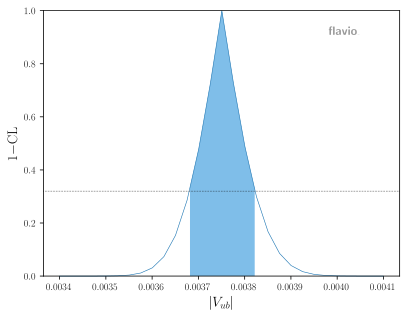

In [12]:
# plot the p value, shading the region with more the 68% confidence
fpl.pvalue_plot(**dat, fill_y=1-0.68)

plt.ylabel(r'$1-$CL')
plt.xlabel(r'$|V_{ub}|$')

# add a dotted line showing the 68% confidence level.
plt.axhline(y=1-0.68, ls=':', c='k', lw=0.6)
fpl.flavio_branding()

## 2D fit to $|V_{ub}|$ and $|V_{cb}|$

Again, we manually remove the fit parameters from the list of nuisance parameters.

In [13]:
fit_Vxb = FrequentistFit(
            name='Frequentist Vub-Vcb fit',
            fit_parameters=['Vub', 'Vcb'],
            nuisance_parameters=[p for p in nuisance if p not in ['Vub', 'Vcb']],
            observables=observables,)

Now compute the profile likelihood in the ranges given

In [14]:
prof2d = Profiler2D(fit_Vxb, 3.3e-3, 4.4e-3, 4.2e-2, 4.9e-2)

In [15]:
%time x, y, z, n = prof2d.run(steps=(10, 10), threads=4)

CPU times: user 665 ms, sys: 268 ms, total: 933 ms
Wall time: 2min 20s


Return the log-likelihood in a form suitable for use with the `contour` plot function. Display the $\Delta \ln\mathcal L$ contours corresponding to 1, 2, and 3$\sigma$.

In [16]:
dat = prof2d.contour_plotdata(n_sigma=(1,2,3))

/usr/local/lib/python3.11/dist-packages/flavio/plots/plotfunctions.py:670: UserWarning: The smallest `z` value on the grid will be used as the minimum of the function to plot. This can lead to undesired results if the actual minimum is considerably different from the minimum on the grid. For better precision, the actual minimum should be provided in the `z_min` argument.
  warnings.warn("The smallest `z` value on the grid will be used as the "


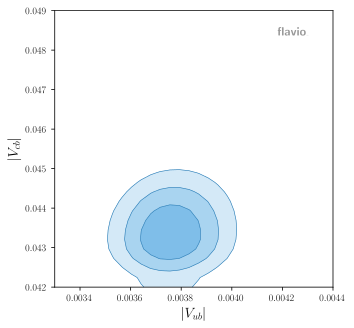

In [17]:
plt.figure(figsize=(5,5))

# use interpolation to get smoother contours
fpl.contour(**dat, interpolation_factor=3)

plt.xlabel(r'$|V_{ub}|$')
plt.ylabel(r'$|V_{cb}|$')

fpl.flavio_branding()